## Import libraries

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import keras
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline 
import sys
import os
!pip install wandb
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from wandb.keras import WandbCallback
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=61095d0035572a9f0b2fd406fe185fb72d9635d14a74e52f7a2d81da67acb4c5
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


## Set initial parameters

In [2]:
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 100
MAX_NB_WORDS = 200000
VALIDATION_SPLIT = 0.2

## Load the Dataset

In [3]:
    
#clean the dataset
def clean_str(string):
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()


#read the training data
train_data = pd.read_csv('train.csv')
train_data.text[1]

train_data

train_data['label'].value_counts()


print(train_data.columns)
print('The raw input data looks like: ')
print(train_data[0:5])

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')
The raw input data looks like: 
   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  


## Vectorize the data

In [4]:
labels =[]
train_data_text =[] 

for index in range(train_data.text.shape[0]):
    text1 = train_data.title[index]
    text2 = train_data.text[index]
    combined_text = str(text1) +""+ str(text2)
    train_data_text.append(combined_text)
    labels.append(train_data.label[index])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_data_text)
sequences = tokenizer.texts_to_sequences(train_data_text)

word_index = tokenizer.word_index
print('There are %s unique tokens.' % len(word_index))



# Pad the input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

There are 251876 unique tokens.
Shape of data tensor: (20800, 1000)
Shape of label tensor: (20800, 2)


## Split the data and apply embeddings

In [5]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( data, labels, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('Real and fake news in train,validation and test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

#Used Pre-trained word Glove embeddings
GLOVE_DIR = "data" 
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[index] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Size of train, validation, test: 16640 10400 10400
Real and fake news in train,validation and test:
[8281. 8359.]
[5237. 5163.]
[5150. 5250.]
Total 400000 word vectors in Glove.


In [7]:
#!pip install wandb

!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Build the CNN model

In [8]:
# custom CNN model
import wandb
from keras.layers import Dropout
input_sequence = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(input_sequence)

#Add first convolutional layer
covolution1= Conv1D(128, 5, activation='relu')(embedded_sequences)
pool1 = MaxPooling1D(5)(covolution1)

#Add dropout layer
dropout1 = Dropout(0.2)(pool1)

#Add second convolutional layer
covolution2 = Conv1D(128, 5, activation='relu')(pool1)
pool2 = MaxPooling1D(5)(covolution2)

#Add dropout layer
dropout2 = Dropout(0.2)(pool2)

#Add third convolutional layer
covolution3 = Conv1D(128, 5, activation='relu')(pool2)
pool3 = MaxPooling1D(35)(covolution3)  # global max pooling

#Add fourth layer
l_flat = Flatten()(pool3)

#Add two dense layers
l_dense = Dense(128, activation='relu')(l_flat)
dropout3 = Dropout(0.2)(l_dense)
predictions = Dense(2, activation='softmax')(l_dense)

#Use wandb to display training accuracy and loss graphs
wandb.init(project="FakeNews")
config = wandb.config
config.learning_rate = 0.01

model = Model(input_sequence, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting the convolutional neural network model")
model.summary()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=128,callbacks=[WandbCallback()])

#!wandb login --relogin

wandb: Currently logged in as: ankithas. Use `wandb login --relogin` to force relogin


Fitting the convolutional neural network model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 100)         25187700  
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 195, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 128)          0         
 1D)          

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/3
130/130 [==============================] - ETA: 0s - loss: 0.6892 - acc: 0.5355

wandb: Adding directory to artifact (/content/wandb/run-20230503_212354-elr39sfv/files/model-best)... Done. 1.7s


130/130 [==============================] - 184s 1s/step - loss: 0.6892 - acc: 0.5355 - val_loss: 0.6765 - val_acc: 0.6073
Epoch 2/3
130/130 [==============================] - ETA: 0s - loss: 0.6678 - acc: 0.6225

wandb: Adding directory to artifact (/content/wandb/run-20230503_212354-elr39sfv/files/model-best)... Done. 1.7s


130/130 [==============================] - 205s 2s/step - loss: 0.6678 - acc: 0.6225 - val_loss: 0.6606 - val_acc: 0.6280
Epoch 3/3
130/130 [==============================] - ETA: 0s - loss: 0.6548 - acc: 0.6305

wandb: Adding directory to artifact (/content/wandb/run-20230503_212354-elr39sfv/files/model-best)... Done. 1.7s


130/130 [==============================] - 183s 1s/step - loss: 0.6548 - acc: 0.6305 - val_loss: 0.6497 - val_acc: 0.6314


## Save the model and plot its metrics

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


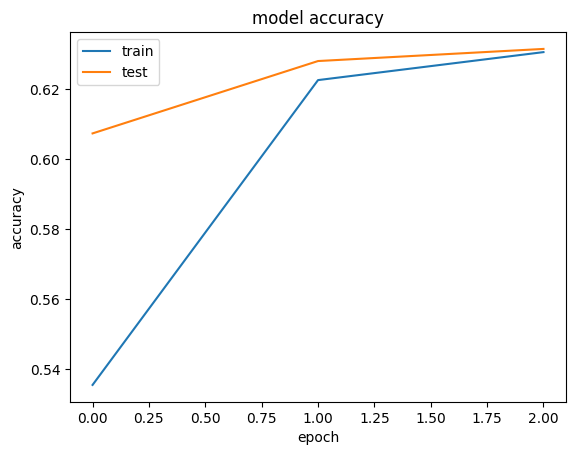

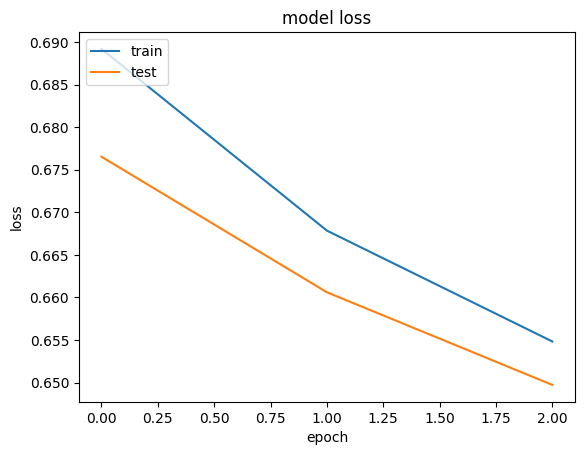

In [9]:
import joblib
model_filename = "cnnepochs3.pkl"
joblib.dump(history.history, model_filename)

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test the model

In [10]:
# Test the model

from sklearn.metrics import accuracy_score

# Test the model
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).flatten()
accuracy = accuracy_score(y_test.flatten(), y_pred)
print(f"Correct number of predictions obtained: {accuracy * len(y_test)}")
print(f"Total number of test examples: {len(y_test)}")
print(f"Accuracy of model: {accuracy:.2%}")

325/325 [==============================] - 20s 60ms/step
Correct number of predictions obtained: 6638.0
Total number of test examples: 10400
Accuracy of model: 63.83%


## Obtain Metrics

325/325 [==============================] - 25s 77ms/step
Test accuracy of the model: 0.6382692456245422
Test loss of the model: 0.6494871973991394


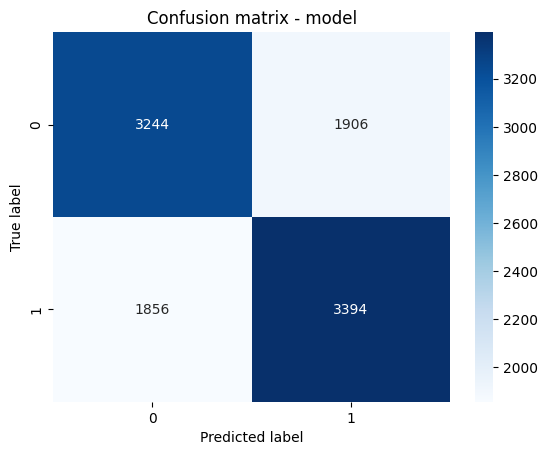

In [12]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test set and get the class with highest probability
y_pred = np.argmax(model.predict(x_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)

# Plot confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion matrix - model')
plt.xlabel('Predicted label')
plt.ylabel('True label')

#Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)

#Display test accuracy and loss
print('Test accuracy of the model:', score[1])
print('Test loss of the model:', score[0])



In [ ]:
#### 5 epochs